In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import h5py
# Load the image




NameError: name 'find_green_puck' is not defined

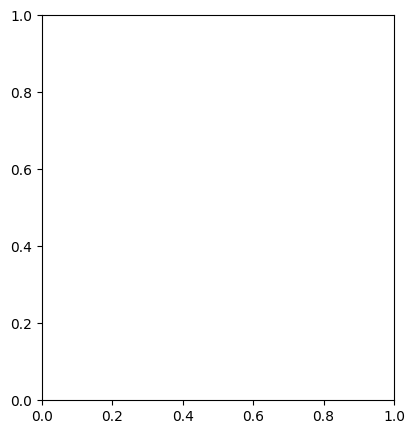

In [12]:
# Let's refine the HSV range based on the user's indication that the puck is on the left side of the image on top of the air hockey table.
# Since the image is quite dark and the puck color is not the typical bright green, we may need to adjust the lower bound of the HSV values.

# Let's first isolate the left side of the image to avoid false positives from other objects

def find_hsv_puck(image, hsv_low=[0,0,0], hsv_high=[255, 255, 255], hsv_alt=None):
    # hsv_alt should e a lit
    # height, w, _ = image.shape
    
    # Convert the left half of the image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # We'll lower the saturation and value thresholds to possibly capture a darker green
    refined_lower_green = np.array([h[0], s[0], v[0]])  # Lower saturation and value
    refined_upper_green = np.array([h[1], s[1], v[1]])
    
    # Create a mask for green color in the left half with the refined thresholds
    refined_mask = cv2.inRange(hsv_image, refined_lower_green, refined_upper_green)
    
    # Bitwise-AND mask and left half of the original image
    puck_idx = np.where(refined_mask)
    refined_result = cv2.bitwise_and(image, image, mask=refined_mask)
    return refined_result, puck_idx
# Display the original left half and result side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

image_path = '/u/mrudolph/documents/ut_airhockey_ur/real_world_human_input/puck_test.jpg'
image = cv2.imread(image_path)
refined_result = find_green_puck(image)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Left Half')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(refined_result, cv2.COLOR_BGR2RGB))
plt.title('Refined Green Puck Detection')
plt.axis('off')

plt.show()


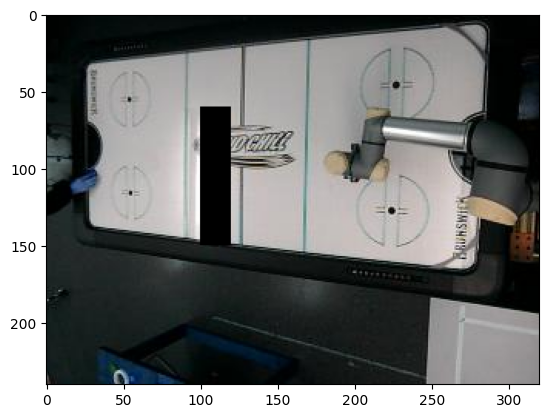

In [16]:
import h5py

def load_hdf5_to_dict(datapath):
    """
    Load a hdf5 dataset into a dictionary.

    :param datapath: Path to the hdf5 file.
    :return: Dictionary with the dataset contents.
    """
    data_dict = {}
    
    # Open the hdf5 file
    with h5py.File(datapath, 'r') as hdf:
        # Loop through groups and datasets
        def recursively_save_dict_contents_to_group(h5file, current_dict):
            """
            Recursively traverse the hdf5 file to save all contents to a Python dictionary.
            """
            for key, item in h5file.items():
                if isinstance(item, h5py.Dataset):  # if it's a dataset
                    current_dict[key] = item[()]  # load the dataset into the dictionary
                elif isinstance(item, h5py.Group):  # if it's a group (which can contain other groups or datasets)
                    current_dict[key] = {}
                    recursively_save_dict_contents_to_group(item, current_dict[key])

        # Start the recursive function
        recursively_save_dict_contents_to_group(hdf, data_dict)

    return data_dict

# To use the function, call it with the actual path to your hdf5 file:

# path = '/datastor1/calebc/public/air_hockey_real_demos/trajectory_data16.hdf5'
path = '/datastor1/calebc/public/data/mouse/trajectories/trajectory_data237.hdf5'
dataset_dict = load_hdf5_to_dict(path)
img = dataset_dict['train_img'][5]
img[60:150, 100:120, :] = 0
plt.imshow(dataset_dict['train_img'][5])

In [14]:
import numpy as np
import cv2

def create_video_from_frames(frame_array, output_path, fps=30):
    """
    Create a video from an array of frames and save to the specified path.

    :param frame_array: A numpy array of shape (N, h, w, 3) containing the frames
    :param output_path: Path where the output video will be saved
    :param fps: Frames per second of the output video
    """
    # Extract the frame dimensions
    N, h, w, _ = frame_array.shape
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' for .mp4 files
    out = cv2.VideoWriter(output_path, fourcc, fps, (w*2, h))
    
    for i in range(N):
        # The frames must be in BGR format for cv2
        # If the frames are in RGB format, convert them to BGR
        # print(cv2.COLOR_RGB2RGB)
        img = frame_array[i]
        # lower HSV: [110  25 119], upper HSV: [125 255 255]
        # lower HSV: [0  100 100], upper HSV: [30 255 255]
        masked_img, idx = find_hsv_puck(frame_array[i], h=[0,30], s=[25,255], v=[119,255]) #cv2.cvtColor(find_green_puck(frame_array[i]), cv2.COLOR_RGB2BGR)
        frame = np.concatenate((img, masked_img), axis=1)
        out.write(frame)  # Write the frame
    
    out.release()  # Release the VideoWriter

# Example usage:
# Assuming 'frames' is a N x h x w x 3 numpy array representing the frames of the video
frames = dataset_dict['train_img'] #np.random.randint(0, 256, (N, h, w, 3), dtype=np.uint8)
# print(frames.shape)
create_video_from_frames(frames, 'output_video.mp4', fps=30)

# Note: Uncomment the line above and define 'N', 'h', 'w' and 'frames' with actual values before running the function.
